In [1]:
avg_salary = 8467
wuxianyijinratio = 0

In [2]:
from bisect import bisect_left
import numpy as np
def old_tax_base(salary):
    #salary = salary/12
    wuxianyijin = np.minimum(np.maximum(salary, 0.6*avg_salary), 3*avg_salary) * wuxianyijinratio + 3
    print(wuxianyijin)
    taxbase = salary - wuxianyijin
    taxbase -= 3500
    buckets = np.array([1500., 4500., 9000., 35000., 55000., 80000.,])
    taxrates = np.array([0.03, 0.1, 0.2, 0.25, 0.3, 0.35, 0.45])
    quickdeduct = np.array([0.0, 105., 555., 1005., 2755., 5505., 13505.])
    i = np.searchsorted(buckets, taxbase, 'left')
    return np.maximum(0, (taxbase * taxrates[i] - quickdeduct[i]))

def old_tax_bonus(bonus, salary):
    buckets = np.array([1500., 4500., 9000., 35000., 55000., 80000.,])
    taxrates = np.array([0.03, 0.1, 0.2, 0.25, 0.3, 0.35, 0.45])
    quickdeduct = np.array([0.0, 105., 555., 1005., 2755., 5505., 13505.])
    i = np.searchsorted(buckets, bonus/12, 'left')
    bonus -= np.maximum(0, 3500-salary/12)
    return np.maximum(0, bonus * taxrates[i] - quickdeduct[i])

def new_tax_total(salary, bonus):
    salary = salary / 12
    wuxianyijin = np.minimum(np.maximum(salary, 0.6*avg_salary), 3*avg_salary) * wuxianyijinratio + 3
    taxbase = (salary - wuxianyijin)*12 - 60000
    total = taxbase + bonus
    buckets = np.array([36000, 144000, 300000, 420000, 660000, 960000])
    taxrates = np.array([0.03, 0.1, 0.2, 0.25, 0.3, 0.35, 0.45])
    quickdeduct = np.array([0.0, 2520., 16920.0, 31920., 52920, 85920., 181920.0])

    i = np.searchsorted(buckets, total, 'left')
    print(total, taxrates[i], quickdeduct[i])
    return np.maximum(0, total * taxrates[i] - quickdeduct[i])

In [3]:
total = np.arange(10000.0, 3005000.0, 10000.0)
bonusratio = np.arange(0.0, 1.0, 0.01)
totalgrid, bonusratiogrid = np.meshgrid(total, bonusratio)
oldtax = old_tax_base(totalgrid*(1-bonusratiogrid)/12)*12 + old_tax_bonus(totalgrid*bonusratiogrid, totalgrid*(1-bonusratiogrid))
newtax = new_tax_total(totalgrid*(1-bonusratiogrid), totalgrid*bonusratiogrid)
difftax = newtax-oldtax

[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]
[[ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]
 [ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]
 [ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]
 ...
 [ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]
 [ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]
 [ -50036.  -40036.  -30036. ... 2919964. 2929964. 2939964.]] [[0.03 0.03 0.03 ... 0.45 0.45 0.45]
 [0.03 0.03 0.03 ... 0.45 0.45 0.45]
 [0.03 0.03 0.03 ... 0.45 0.45 0.45]
 ...
 [0.03 0.03 0.03 ... 0.45 0.45 0.45]
 [0.03 0.03 0.03 ... 0.45 0.45 0.45]
 [0.03 0.03 0.03 ... 0.45 0.45 0.45]] [[     0.      0.      0. ... 181920. 181920. 181920.]
 [     0.      0.      0. ... 181920. 181920. 181920.]
 [     0.      0.      0. ... 181920. 181920. 181920.]
 ...
 [     0.      0.      0. ... 181920. 181920. 181920.]
 [     0.      0.  

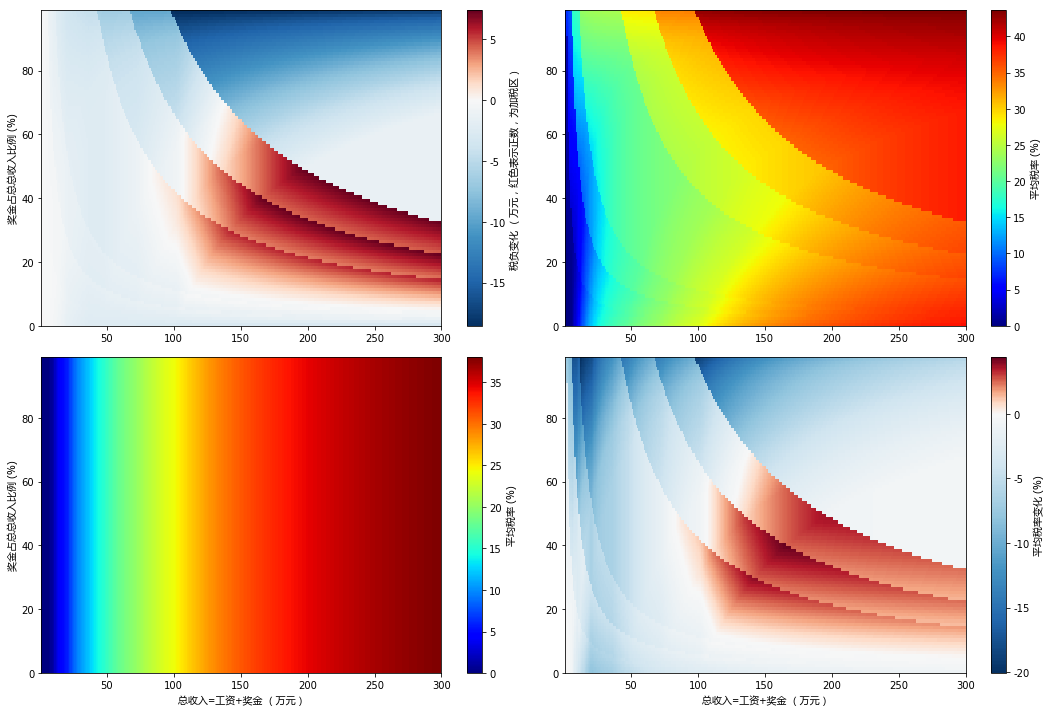

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.font_manager import *  
#plt.rc('font', family='Microsoft YaHei')
myfont = FontProperties(fname='/home/booksword/.local/share/fonts/微软雅黑繁简完全版.ttf')
matplotlib.rcParams['axes.unicode_minus']=False


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

clabels = ('税负变化 （万元，红色表示正数，为加税区）', '平均税率 (%)', '平均税率 (%)', '平均税率变化 (%)')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
(ax0, ax1), (ax2, ax3) = axes
ims = []
for idx, ax, data, clabel in zip(range(4), axes.flatten(), (difftax/10000, oldtax/totalgrid*100, newtax/totalgrid*100, difftax/totalgrid*100), clabels):
    im = ax.pcolormesh(totalgrid/10000, bonusratiogrid*100, data, norm = MidpointNormalize(midpoint=0.) if idx in (0, 3) else None, cmap='RdBu_r' if idx in (0, 3) else 'jet')
    ims.append(im)
    cb = fig.colorbar(im, ax=ax, label=clabel)
    cb.set_label(label=clabel,fontproperties=myfont)
    


for ax in (ax2, ax3):
    ax.set_xlabel('总收入=工资+奖金 （万元）',fontproperties=myfont)
for ax in (ax0, ax2):
    ax.set_ylabel('奖金占总总收入比例 (%)',fontproperties=myfont)
plt.tight_layout()
plt.savefig("/mnt/Win10Document/Documents/GitHub/booksword_blog/utils/taxchange.png")

In [126]:
test

(<Figure size 432x288 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07769a6550>,
       dtype=object))

In [132]:
difftax.flatten()

array([      0.     ,       0.     ,       0.     , ..., -187090.27168,
       -187049.02168, -187007.77168])

In [193]:
bonus = 100000
bounstax = 19445.00
salary = [45000, 48434+2240.25, 48334, 48334, ]
tax = [8278.30, 9980.58, 9278, ]

In [194]:
for s in salary:
    print(old_tax_base(s))

4722.276
8278.3172
4722.276
9980.592200000001
4722.276
9278.5172


In [201]:
new_tax_total(529100.96, 100000)

569064.96 0.3 52920.0


117799.48799999998

In [191]:
detail = avg_salary*np.array([0.12, 0.08, 0.02, 0.002])*3
detail[2]+=3
(detail, detail.sum())

(array([2550.96 , 1700.64 ,  428.16 ,   42.516]), 4722.276)

In [190]:
detail

array([2550.96 , 1700.64 ,  428.16 ,   42.516])

In [16]:
(0.2/(1-0.2)*12, 0.6/(1-0.6)*12)

(3.0, 17.999999999999996)